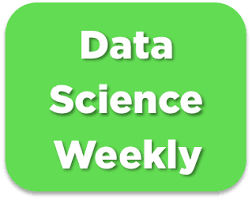

# Challenge : predict conversions 🏆🏆

Les data scientists qui ont créé la newsletter souhaitent mieux comprendre le comportement des utilisateurs visitant leur site web. Ils aimeraient savoir s'il est possible de construire un modèle qui prédit si un utilisateur donné s'abonnera à la newsletter, en utilisant seulement quelques informations sur l'utilisateur. Ils souhaitent analyser les paramètres du modèle pour mettre en évidence des fonctionnalités importantes pour expliquer le comportement des utilisateurs, et peut-être découvrir un nouveau levier d'action pour améliorer le taux de conversion de la newsletter.

Ils ont conçu un concours visant à construire un modèle permettant de prédire les conversions (c'est-à-dire quand un utilisateur s'abonnera à la newsletter). Pour ce faire, ils ont ouvert un ensemble de données contenant des données sur le trafic sur leur site Web. Pour évaluer les classements des différentes équipes en compétition, ils ont décidé d'utiliser le f1-score .

**Objectifs**  
    1) EDA  
    2) Modèle de machine learning  
    3) Predictions et test du modèle

# Importation des librairies

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split, learning_curve,GridSearchCV
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler , OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, confusion_matrix, classification_report
from sklearn.pipeline import Pipeline

import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
# setting Jedha color palette as default
pio.templates["jedha"] = go.layout.Template(
    layout_colorway=["#4B9AC7", "#4BE8E0", "#9DD4F3", "#97FBF6", "#2A7FAF", "#23B1AB", "#0E3449", "#015955"]
)
pio.templates.default = "jedha"
pio.renderers.default = "iframe" 

# Chargement du dataSet train 

In [2]:
df = pd.read_csv('conversion_data_train.csv')
df.head()

,country,age,new_user,source,total_pages_visited,converted
0,China,22,1,Direct,2,0
1,UK,21,1,Ads,3,0
2,Germany,20,0,Seo,14,1
3,US,23,1,Seo,3,0
4,US,28,1,Direct,3,0


In [3]:
df.shape

(284580, 6)

In [4]:
df['converted'].value_counts()

0    275400
1      9180
Name: converted, dtype: int64

Le Dataset est très gros, mon oridnateur ne surporte pas un trop gros volume de données. Je vais donc utiliser que 100.000 lignes(environ 50% du dataset) pour la partie machine learning

In [5]:
data_model = df.sample(100000, random_state = 0,)

#je prends qu'une partie de mon dataset (100.000 lignes). Pour faciliter mon ordinateur à réaliser le gridsearchCV 

In [6]:
data_model.shape

(100000, 6)

# Informations sur le DataSet

In [7]:
print('data shape {}'.format(df.shape))
print()

print('data description :')
display(df.describe())
print()

print('data info :')
display(df.info())
print()

data shape (284580, 6)

data description :


,age,new_user,total_pages_visited,converted
count,284580.000000,284580.000000,284580.000000,284580.000000
mean,30.564203,0.685452,4.873252,0.032258
std,8.266789,0.464336,3.341995,0.176685
min,17.000000,0.000000,1.000000,0.000000
25%,24.000000,0.000000,2.000000,0.000000
50%,30.000000,1.000000,4.000000,0.000000
75%,36.000000,1.000000,7.000000,0.000000
max,123.000000,1.000000,29.000000,1.000000



data info :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284580 entries, 0 to 284579
Data columns (total 6 columns):
 #   Column               Non-Null Count   Dtype 
---  ------               --------------   ----- 
 0   country              284580 non-null  object
 1   age                  284580 non-null  int64 
 2   new_user             284580 non-null  int64 
 3   source               284580 non-null  object
 4   total_pages_visited  284580 non-null  int64 
 5   converted            284580 non-null  int64 
dtypes: int64(4), object(2)
memory usage: 13.0+ MB


None

In [8]:
df['converted'].value_counts()

0    275400
1      9180
Name: converted, dtype: int64

- Variables-cible : Y = 'converted', valeur 1 est sous représentée
- Variables explicatives : 'country',	'age', 'new_user',	'source',	'total_pages_visited'
- Nombre d'exemples : 316200

- pas d'imputation de valeurs manquantes
- Normalisation : 'age', 'total_pages_visited'
- Encodage des variables catégorielles : 'country', 'new_user', 'source'

In [9]:
for column in df.columns:
    print('colonne {}'.format(column))
    display(df[column].isnull().mean())
    display(df[column].value_counts())

colonne country


0.0

US         160124
China       69122
UK          43641
Germany     11693
Name: country, dtype: int64

colonne age


0.0

28     12972
30     12956
29     12710
27     12668
26     12525
31     12327
25     12157
32     12111
24     11647
33     11392
23     11097
34     10911
22     10471
35     10352
21      9870
36      9668
20      9131
37      8773
19      8452
38      8067
18      7662
39      7343
17      6825
40      6451
41      5783
42      5029
43      4423
44      3808
45      3249
46      2693
47      2255
48      1898
49      1467
50      1213
51       990
52       835
53       571
54       459
55       352
56       251
57       211
58       147
59       115
60        86
61        63
62        50
63        29
64        26
65        14
66         9
67         5
68         2
70         2
69         1
72         1
73         1
77         1
79         1
111        1
123        1
Name: age, dtype: int64

colonne new_user


0.0

1    195066
0     89514
Name: new_user, dtype: int64

colonne source


0.0

Seo       139477
Ads        80027
Direct     65076
Name: source, dtype: int64

colonne total_pages_visited


0.0

2     39546
3     39465
4     36918
1     36637
5     32654
6     27198
7     21112
8     15768
9     10972
10     7312
11     4846
12     3233
13     2191
14     1611
15     1196
16      997
17      767
18      653
19      506
20      372
21      266
22      162
23       99
24       40
25       34
26       15
27        7
29        2
28        1
Name: total_pages_visited, dtype: int64

colonne converted


0.0

0    275400
1      9180
Name: converted, dtype: int64

**Remarque**  
Nous avons deux valeurs abérentes dans la colonne âge, avec un visiteur qui avait 123 ans et un autre 111 ans. 

C:\Users\marti\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\marti\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\marti\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\marti\anaconda3\lib\site-pac

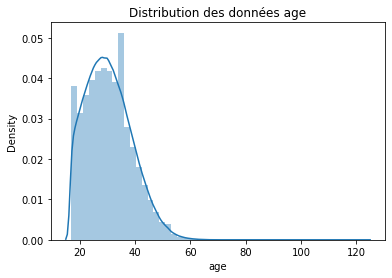

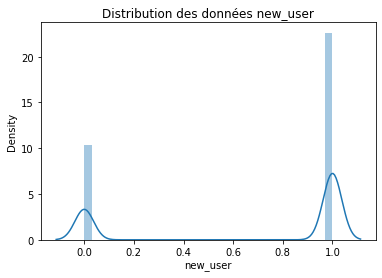

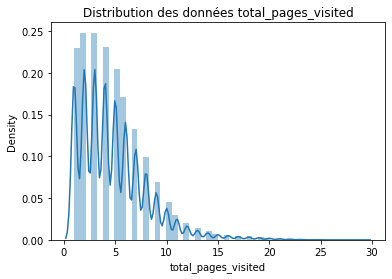

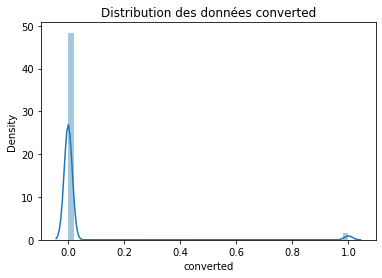

In [10]:
for col in data_model.select_dtypes('int64'):
    plt.figure()
    sns.distplot(df[col])
    plt.title('Distribution des données {}'.format(col))

Nous allons reprendre ces résultats, mais cette fois-ci nous allons regarder la distribution des variables, en sachant si le visiteur est convertit ou non.

In [11]:
converted_df = df[df['converted'] == 1]
no_converted_df = df[df['converted'] == 0]

C:\Users\marti\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\marti\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\marti\anaconda3\lib\site-packages\seaborn\distributions.py:2557: FutureWarning:

`distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).

C:\Users\marti\anaconda3\lib\site-pac

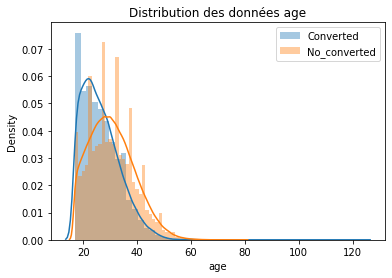

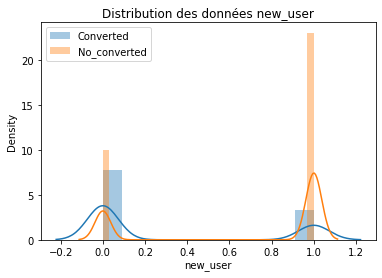

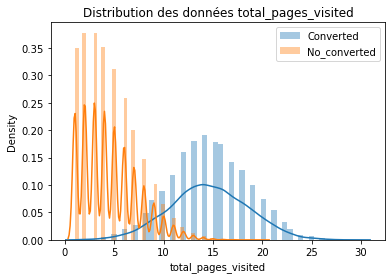

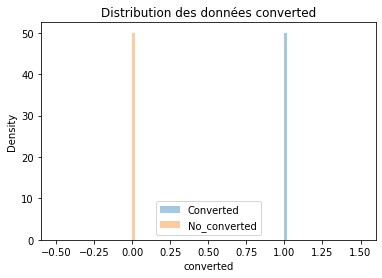

In [12]:
for col in data_model.select_dtypes('int64'):
    plt.figure()
    sns.distplot(converted_df[col], label = 'Converted')
    sns.distplot(no_converted_df[col], label = 'No_converted')
    plt.legend()
    plt.title('Distribution des données {}'.format(col))

**Résultats**  
Les résultats sont très intéressants !  
    Il est plus problable qu'une personne s'abonne si :  
            - La personne est jeune  
            - Elle visite plusieurs fois le site  
            - Elle visite plus de 7 pages du site inernet  

# Regression Logistic ! 

Dans un premier temps je vais créer une fonction pour le preprocessing.  
Comme indiqué au début du notebook, je vais garder environ 50% du dataset pour avoir une meilleure performance de mon ordinateur.

In [13]:
trainset, testset = train_test_split(data_model, test_size = 0.2, random_state = 0 )

In [14]:
print(trainset['converted'].value_counts())
print(testset['converted'].value_counts())

0    77348
1     2652
Name: converted, dtype: int64
0    19379
1      621
Name: converted, dtype: int64


In [15]:
def preprocessing(df):
    """
    La fonction sépare les features de la target
    
    IN : dataset
    
    OUT : X --> Features
          y --> Target
    """
    X = df.drop('converted', axis=1)
    y = df['converted']
    
    return X, y 

In [16]:
X_train, y_train = preprocessing(trainset) # On obtient les données d'entraînements

In [17]:
X_test, y_test = preprocessing(testset) # On onbtient les données de tests

In [18]:
# Pipeline 
numeric_feature = [1,4] 
categorical_feature = [0,2,3]

numeric_transformer = Pipeline(steps =[('scaler', StandardScaler())])
categorical_transformer = Pipeline(steps = [('encoder', OneHotEncoder(drop = 'first'))])

preprocessor = ColumnTransformer(transformers =[
    ('num', numeric_transformer, numeric_feature),
    ('cat', categorical_transformer, categorical_feature)
                                                ])

In [19]:
# Transformation des variables
# On applique le pipeline aux données de train et de test
X_train = preprocessor.fit_transform(X_train)
X_test = preprocessor.transform(X_test)

In [20]:
def evaluation(model):
    """ 
    IN : model
    
    Cette fonction permet :
     - Entraîner le modèle aux données d'entrainement
     - Appliquer le modèle aux données de test
     - Obtenir une matrice de confusion et l'ensemble des métrics du résultat
     - Ontenir un graphique de learning curve
    """
    model.fit(X_train, y_train)
    ypred_train = model.predict(X_train)
    ypred_test = model.predict(X_test)
    
    print(confusion_matrix(y_test, ypred_test))
    print(classification_report(y_test, ypred_test))
    print("f1-score on train set : ", f1_score(y_train, ypred_train))
    print("f1-score on test set : ", f1_score(y_test, ypred_test))
    
    N, train_score, val_score = learning_curve(model, X_train, y_train,
                                              cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
    plt.figure(figsize=(12, 8))
    plt.plot(N, train_score.mean(axis=1), label='train score')
    plt.plot(N, val_score.mean(axis=1), label='validation score')
    plt.legend()

**Learning curve**  
Courbes d'apprentissage qui montre l'évolution des performances du modèle en fonction de la quantité de données qu'on lui fournit.  
  
*train_sizes*  --> les quantités de données qu'on va fournir pour l'entraînement (en pourcentage)  
*N* --> Variable qui contient les données fournis par le train_sizes

In [21]:
model = LogisticRegression()

[[19296    83]
 [  182   439]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99     19379
           1       0.84      0.71      0.77       621

    accuracy                           0.99     20000
   macro avg       0.92      0.85      0.88     20000
weighted avg       0.99      0.99      0.99     20000

f1-score on train set :  0.7626442812172087
f1-score on test set :  0.7681539807524059


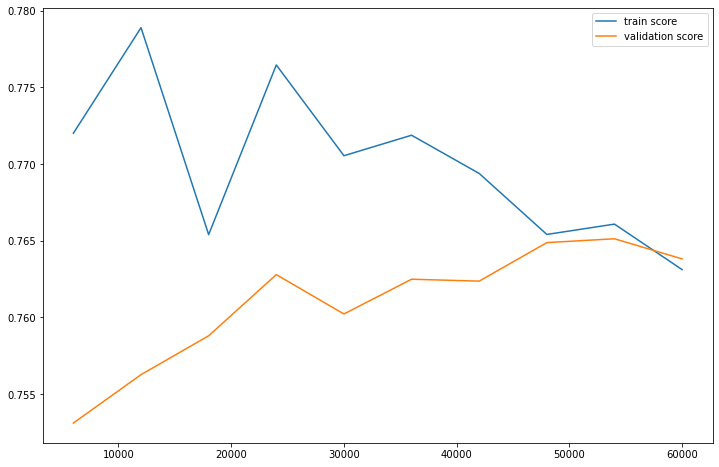

In [22]:
evaluation(model)

# Test des différents modèles

In [23]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import make_pipeline

In [24]:
RandomForest = make_pipeline(RandomForestClassifier(random_state=0))
AdaBoost = make_pipeline(AdaBoostClassifier(random_state=0))
SVM = make_pipeline(SVC(random_state=0))
KNN = make_pipeline(KNeighborsClassifier())

In [25]:
dict_of_models = {'RandomForest': RandomForest,
                  'AdaBoost' : AdaBoost,
                  'SVM': SVM,
                  'KNN': KNN
                 }

RandomForest
[[19258   121]
 [  200   421]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     19379
           1       0.78      0.68      0.72       621

    accuracy                           0.98     20000
   macro avg       0.88      0.84      0.86     20000
weighted avg       0.98      0.98      0.98     20000

f1-score on train set :  0.8436988543371522
f1-score on test set :  0.7239896818572658
AdaBoost
[[19282    97]
 [  191   430]]
              precision    recall  f1-score   support

           0       0.99      0.99      0.99     19379
           1       0.82      0.69      0.75       621

    accuracy                           0.99     20000
   macro avg       0.90      0.84      0.87     20000
weighted avg       0.98      0.99      0.99     20000

f1-score on train set :  0.7539748953974895
f1-score on test set :  0.7491289198606271
SVM
[[19313    66]
 [  210   411]]
              precision    recall  f1-score   support

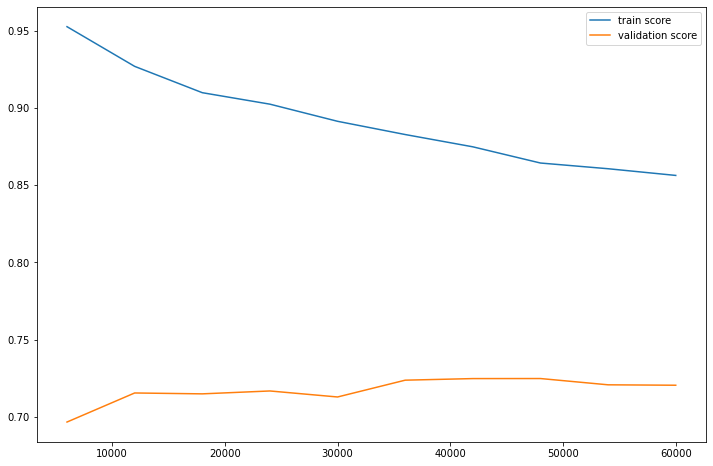

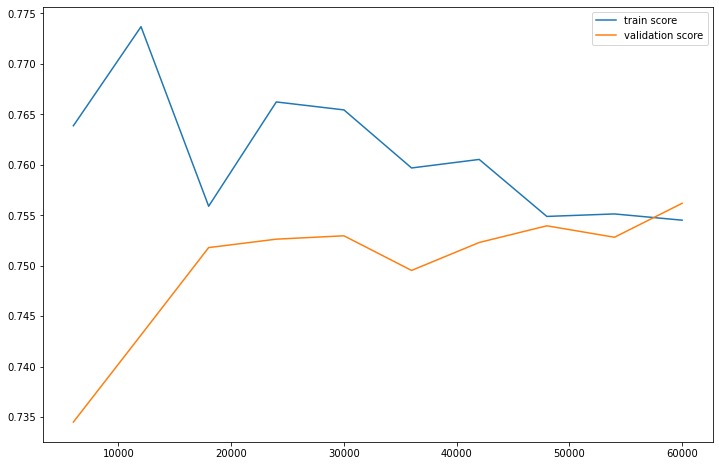

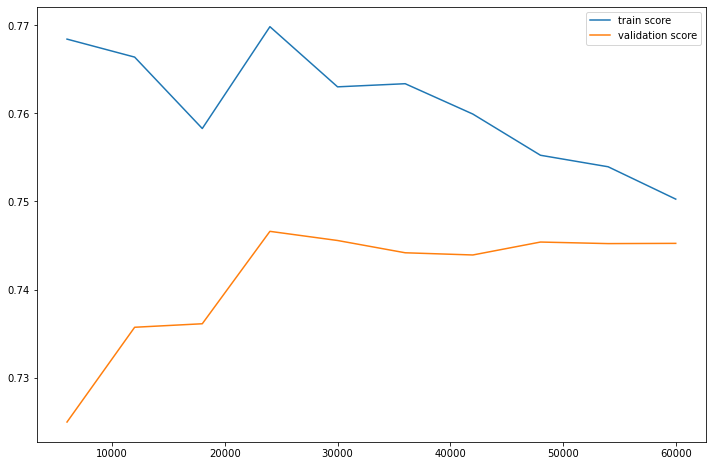

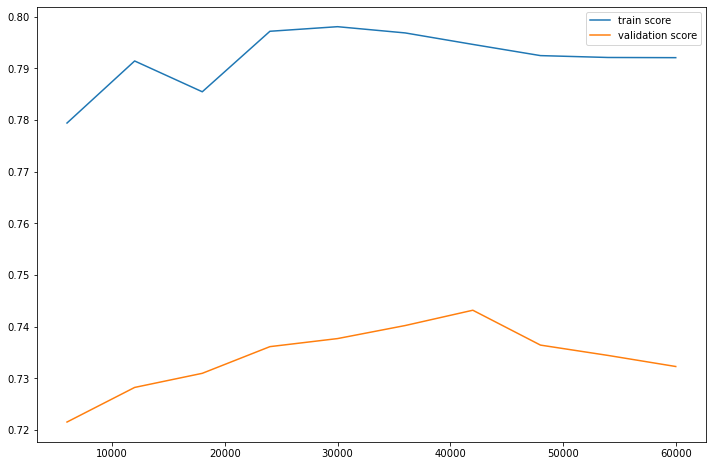

In [26]:
for name, model in dict_of_models.items():
    print(name)
    evaluation(model)

**Résultats**  
On remarque que le le modèle de RandomForest présente les meilleurs résultats(sur les données train). Cependant, la différence du f1 score entre les données train et test de ce modèle, sont important.
On devine sur le graphique (learning curve) qu'il manque des données pour une amélioration du model.  
Rappel: j'ai moi même diminué le nombre de données pour des raisons matérielles.

**Amélioration du model**  
J'ai choisi de me concentrer sur le model du randon Forest pour effectuer un grid searchCV.  
Le Gris Search CV permet de tester le modèle en modifiants plusieurs de ces paramètre pour l'optimiser.

In [27]:
forest = RandomForestClassifier(random_state=0)

hyper_params = {
    'n_estimators' : [20,50,100],
    'max_depth' : [5,10]
}

grid = GridSearchCV(forest, hyper_params, cv=5, scoring ='f1', verbose = 1)

grid.fit(X_train, y_train)
forest_best = grid.best_estimator_

Fitting 5 folds for each of 6 candidates, totalling 30 fits


In [28]:
# Best score
print("best {0} score on the train set : \n {1} \n best {0} score on the test set : \n {2}".format("Forest", forest_best.score(X_train,y_train), forest_best.score(X_test,y_test)))
print()

y_train_pred = forest_best.predict(X_train)
y_test_pred = forest_best.predict(X_test)
f1_train_Tree = f1_score(y_train, y_train_pred)
f1_test_Tree = f1_score(y_test, y_test_pred)

print("f1-score on train set : ", f1_score(y_train, y_train_pred))
print("f1-score on test set : ", f1_score(y_test, y_test_pred))

best Forest score on the train set : 
 0.98805 
 best Forest score on the test set : 
 0.9854

f1-score on train set :  0.7981418918918919
f1-score on test set :  0.7411347517730495


In [29]:
forest_best

RandomForestClassifier(max_depth=10, n_estimators=20, random_state=0)

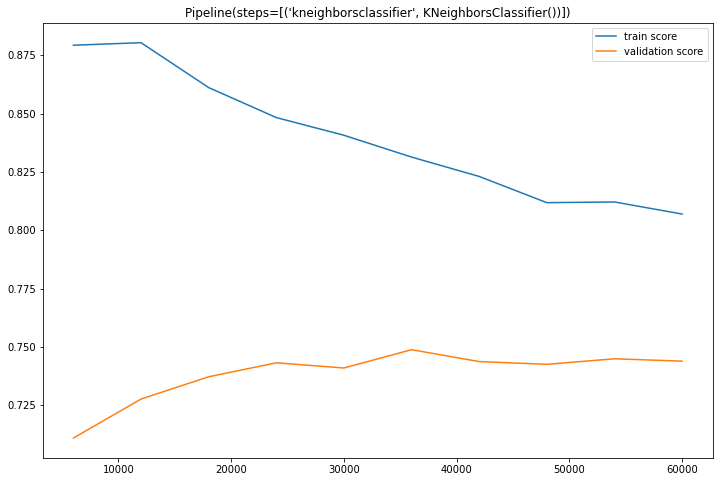

In [30]:
N, train_score, val_score = learning_curve(forest_best, X_train, y_train,
                                              cv=4, scoring='f1',
                                               train_sizes=np.linspace(0.1, 1, 10))
    
    
plt.figure(figsize=(12, 8))
plt.plot(N, train_score.mean(axis=1), label='train score')
plt.plot(N, val_score.mean(axis=1), label='validation score')
plt.title(model)
plt.legend()

Le Grid Search CV à permis d'optimiser notre modèle.  



**Conclusion**  
L'EDA  nous a permis de montrer que certaines varibles sont directement liées au choix de l'utilisateur de s'abonner ou non . 
  
Après avoir entraîner plusieurs modèles, je me suis concentrer sur le random forest. On obtient des résultats intéressant:  
Pas d'over fiting. Le graphique de learning curve montre qu'avec plus de données il sera possible d'améliorer le modèle.